## Synthetic data

Small example of how to use the synthetic data generator. Not sure if we will include this or a version of this in the public release of TOAD, but I think it's good for testing TOAD.


In [1]:
# Prerequisites
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
from toad import TOAD
from toad.shifts_detection.methods import ASDETECT
from sklearn.cluster import HDBSCAN
from toad.visualisation.toad_plotter import PlotConfig
from toad.utils import create_global_dataset

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 200, lat: 20, lon: 40)
Coordinates:
  * time     (time) float64 2kB 0.0 0.5025 1.005 1.508 ... 98.99 99.5 100.0
  * lat      (lat) float64 160B -90.0 -80.53 -71.05 -61.58 ... 71.05 80.53 90.0
  * lon      (lon) float64 320B -180.0 -170.8 -161.5 ... 161.5 170.8 180.0
    x        (lat, lon) float64 6kB -3.919e-13 -3.868e-13 ... -3.919e-13
    y        (lat, lon) float64 6kB -4.799e-29 -6.286e-14 ... 4.799e-29
    z        (lat, lon) float64 6kB -6.357e+03 -6.357e+03 ... 6.357e+03
Data variables:
    value    (time, lat, lon) float64 1MB 0.01624 -0.004009 ... -0.003525

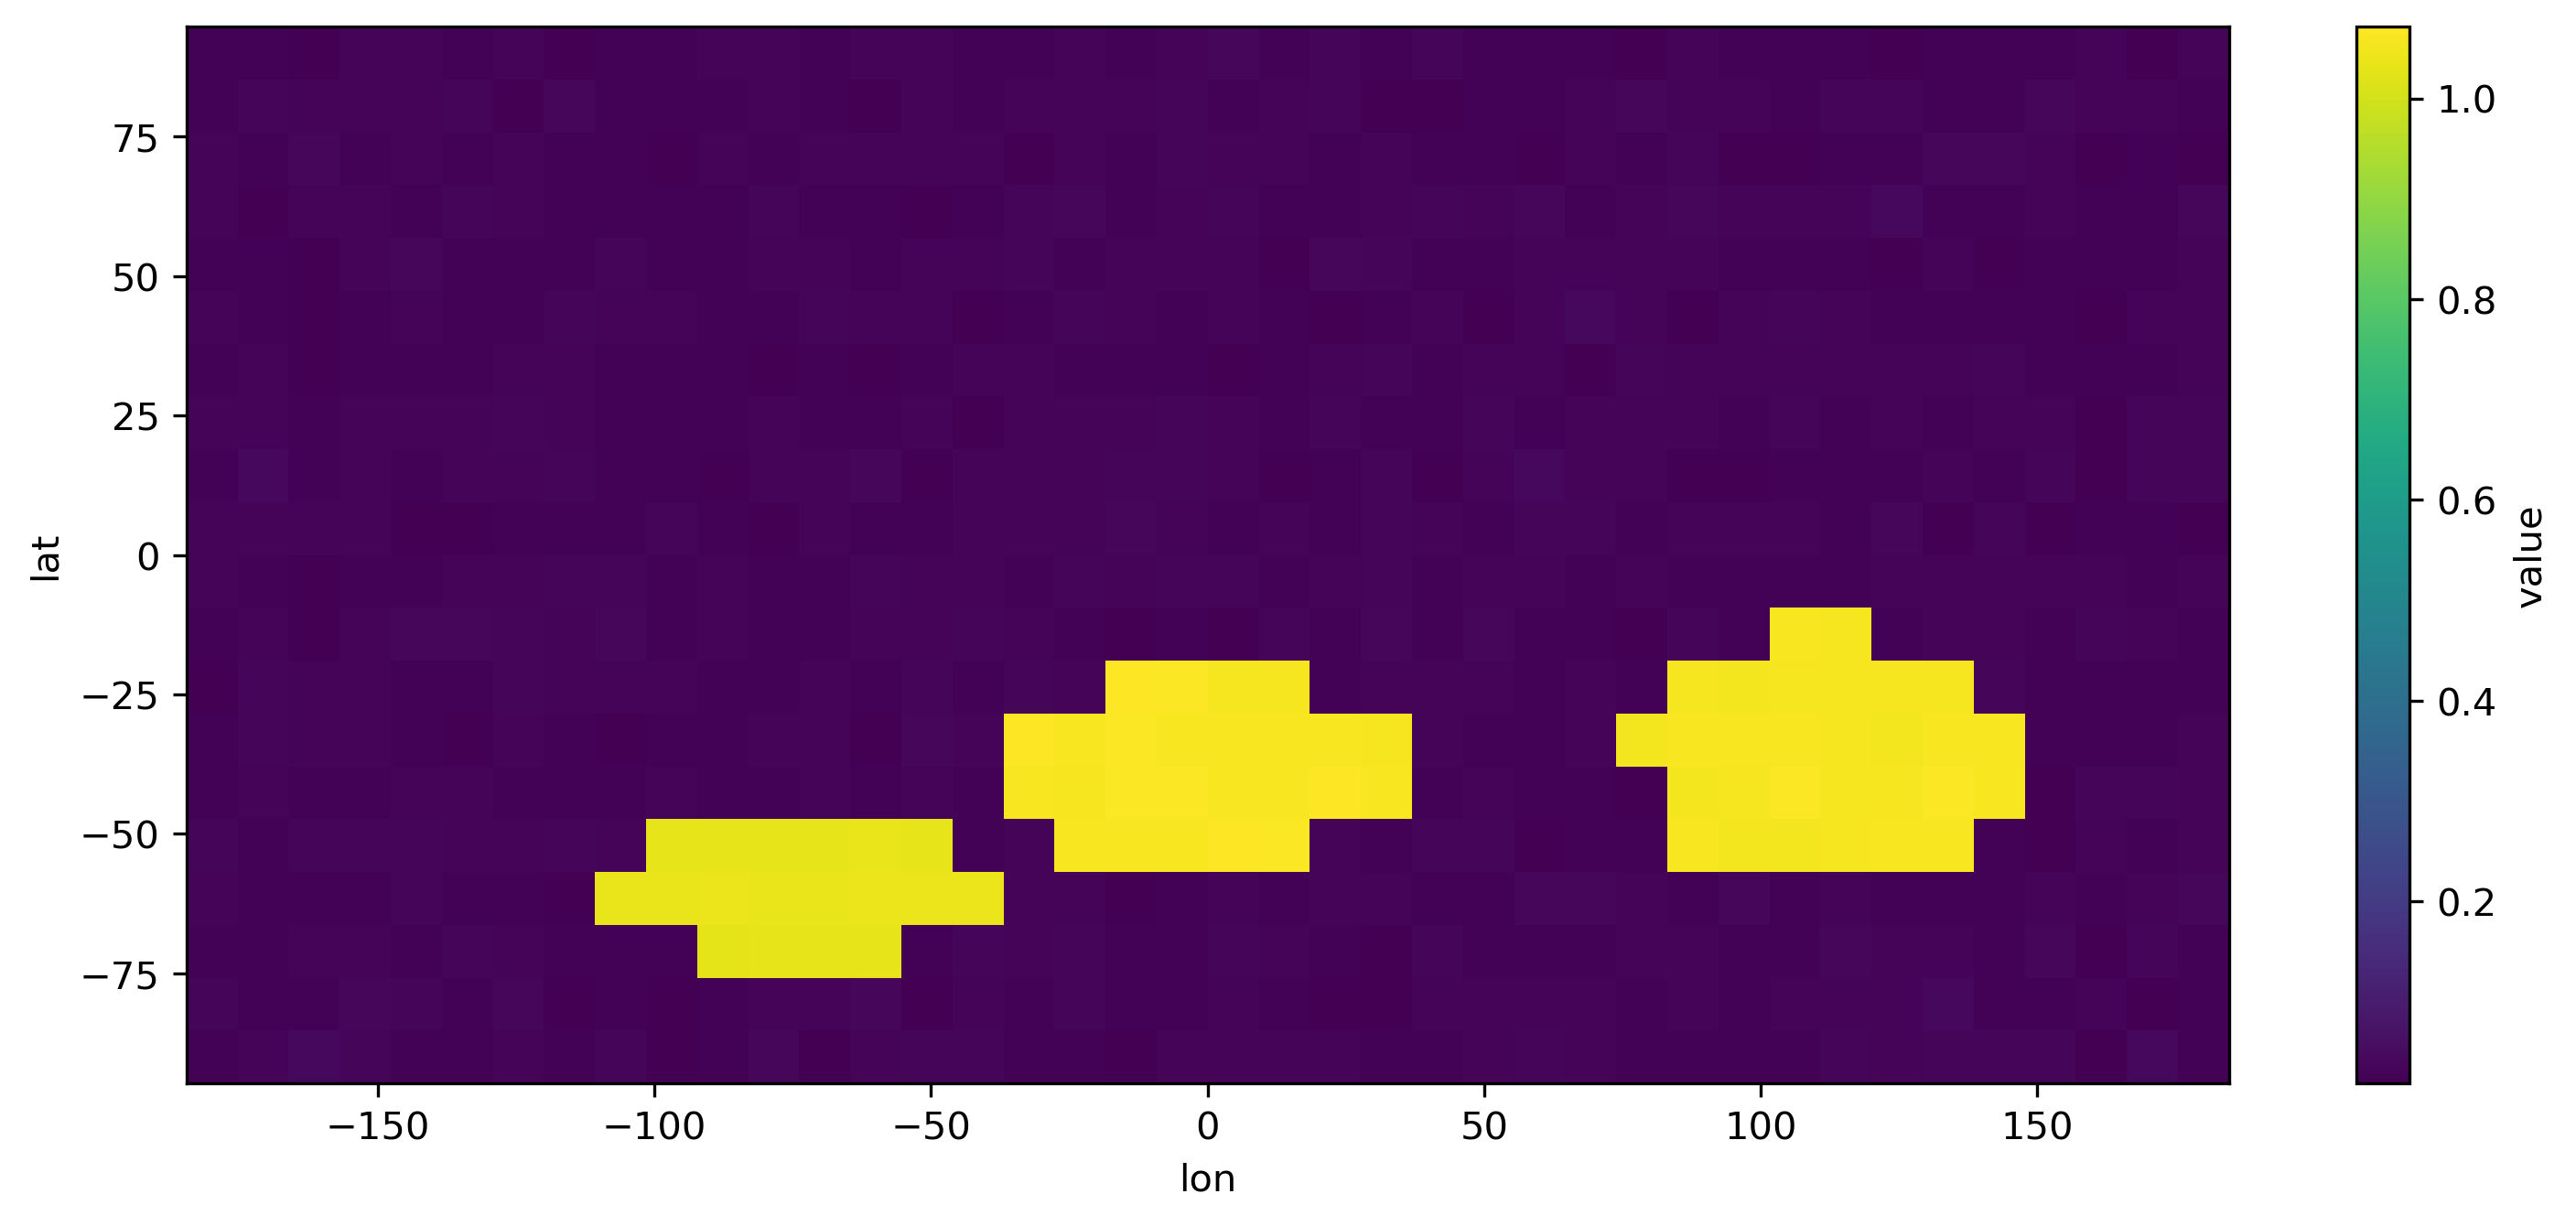

In [18]:
# Generate syntheitc data
data_ds, labels_xr, shift_params = create_global_dataset(
    lat_size=20,
    lon_size=40,
    time_size=200,
    n_shifts=3,
    random_seed=1,
    background_noise=0.01,
    background_trend=0.0,
)

data_ds.value.max(dim="time").plot()
data_ds

Create different synthetic data sets from random seed, compute shifts and clusters, and plot along with true regions of shift.


In [9]:
# from ipywidgets import interact
# @interact(random_seed=(1, 100, 1))
def plot(random_seed=0):
    data_ds, labels_xr, shift_params = create_global_dataset(
        20,
        40,
        time_size=200,
        n_shifts=3,
        random_seed=random_seed,
        background_noise=0.01,
    )

    td = TOAD(data_ds)
    td.compute_shifts("value", ASDETECT())
    td.compute_clusters(
        "value",
        HDBSCAN(min_cluster_size=10),
        shifts_filter_func=lambda x: abs(x) > 0.9,
    )

    plt.rcParams["figure.dpi"] = 300

    plotter = td.plotter(
        PlotConfig(
            map_frame=False,
            grid_labels=False,
        )
    )

    plotter.cluster_overview(
        "value",
        range(10),
        cmap="tab10",
        timeseries_kwargs={},
        map_kwargs={"add_contour": False},
        figsize=(16, 5),
    )

    # Plot true shift locations
    fig, ax = plotter.map(figsize=(16, 4))
    labels_xr.max(dim="time").plot(ax=ax, cmap="Blues")
    ax.set_title("True shift locations")

    # plot cluster timeseries
    fig, axs = plt.subplots(2, 1, figsize=(16, 4))
    plotter.cluster_timeseries("value", td.get_cluster_ids("value"), ax=axs[0])

    # plot data timeseries
    td.data.value.toad.to_timeseries().plot.line(
        x="time", add_legend=False, color="k", alpha=0.1, ax=axs[1]
    )
    axs[0].set_title(f"Cluster {td.get_cluster_ids('value')} timeseries")
    axs[1].set_title("All data timeseries")

#### Example of well working clusters


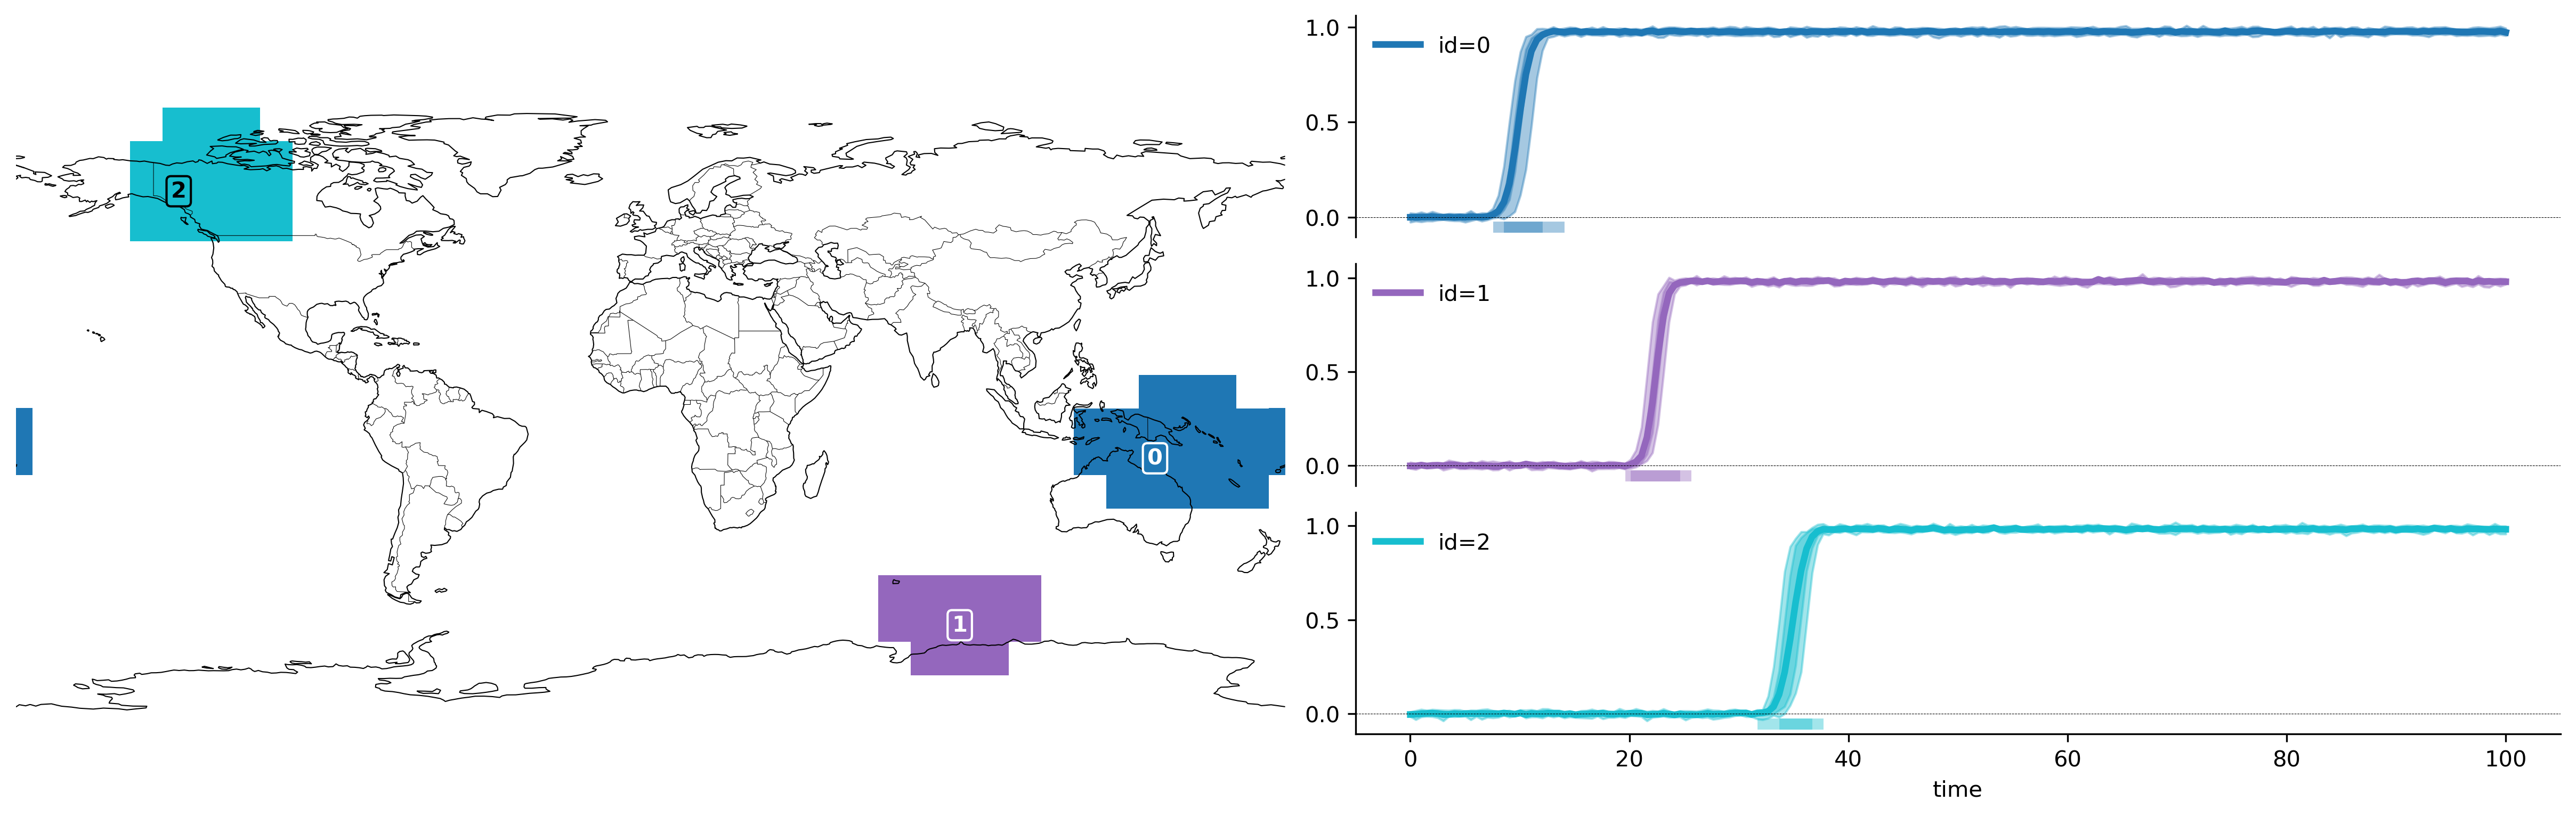

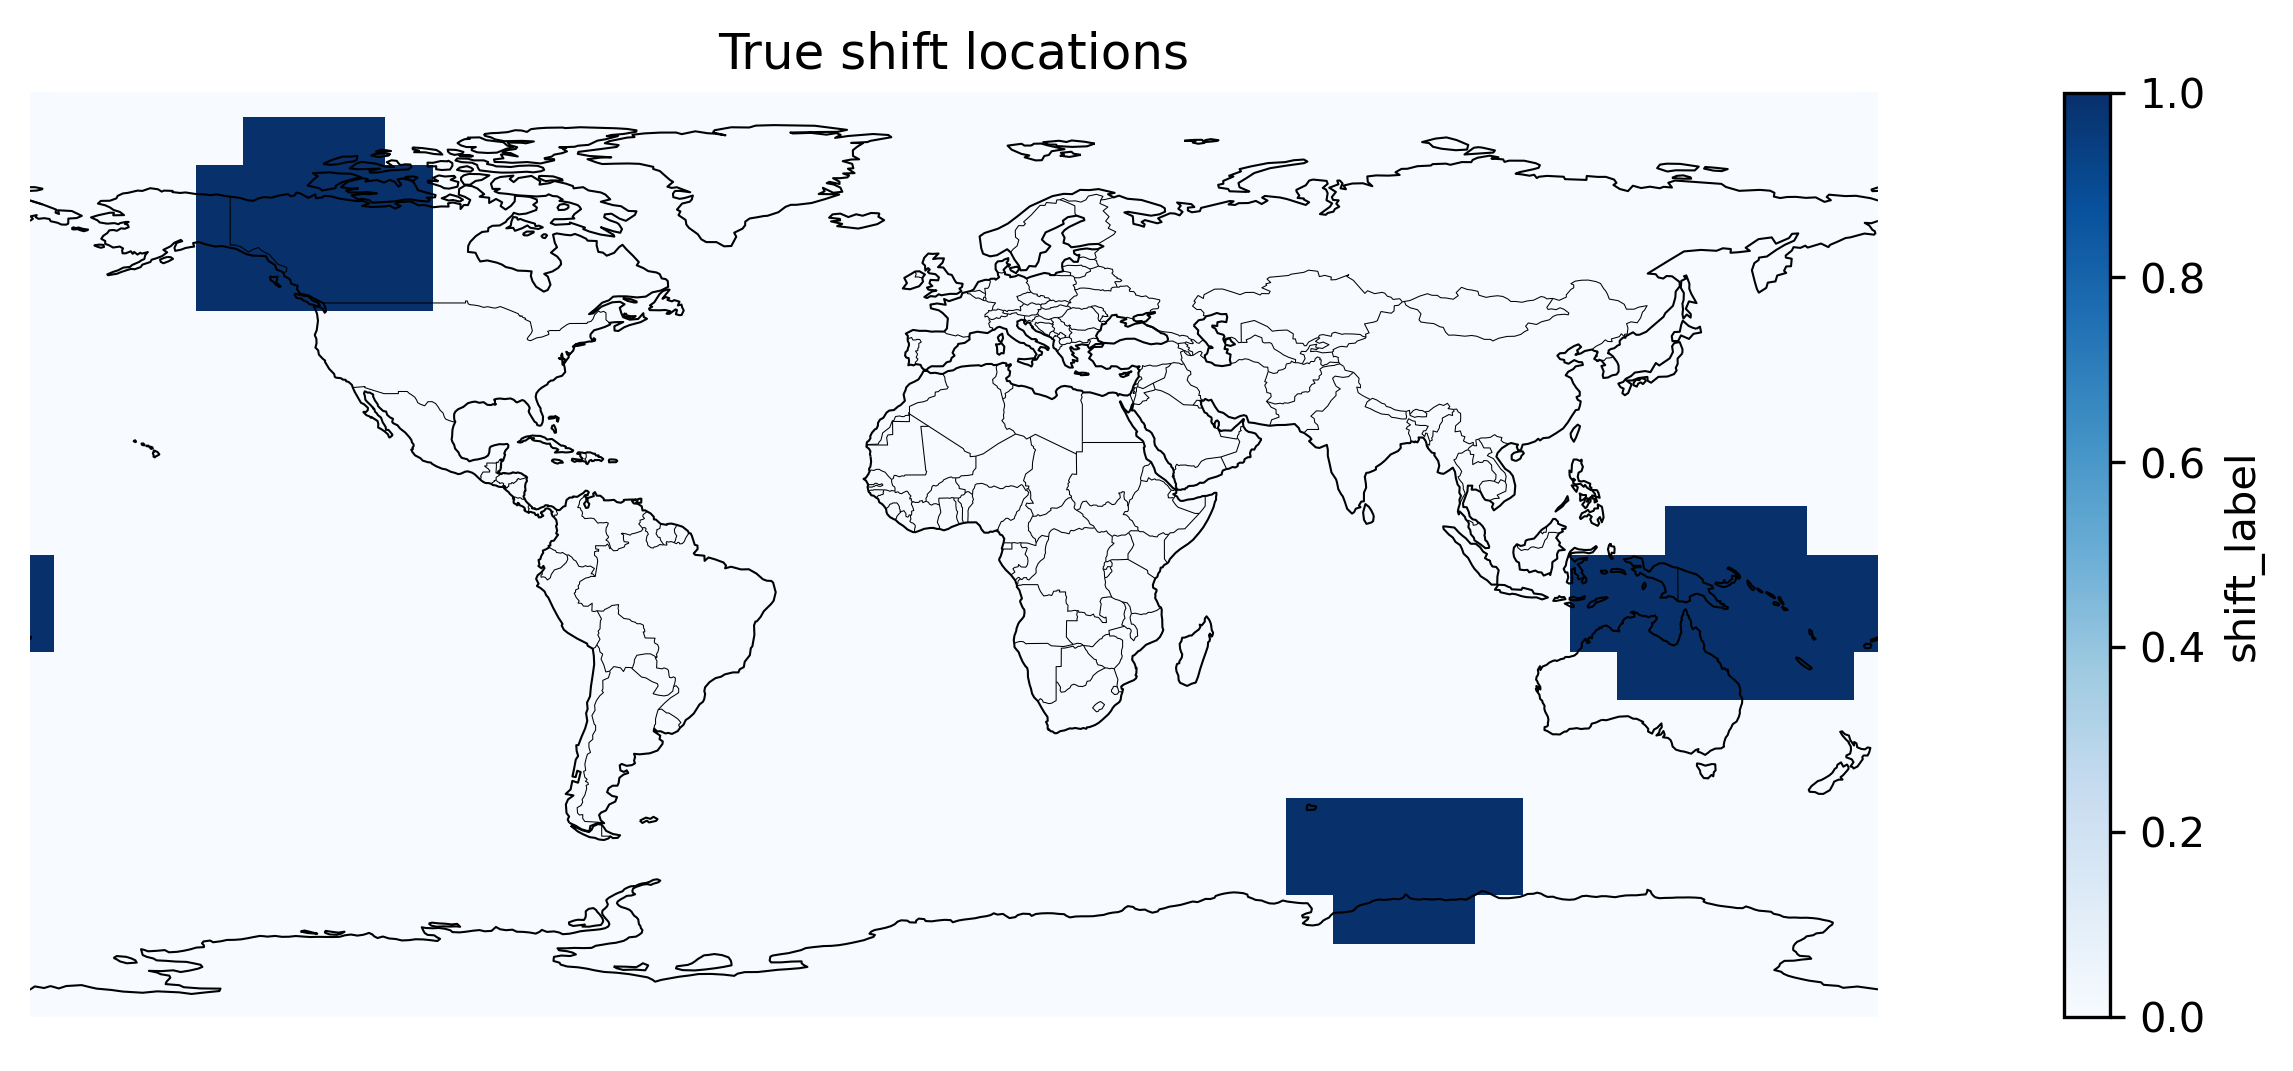

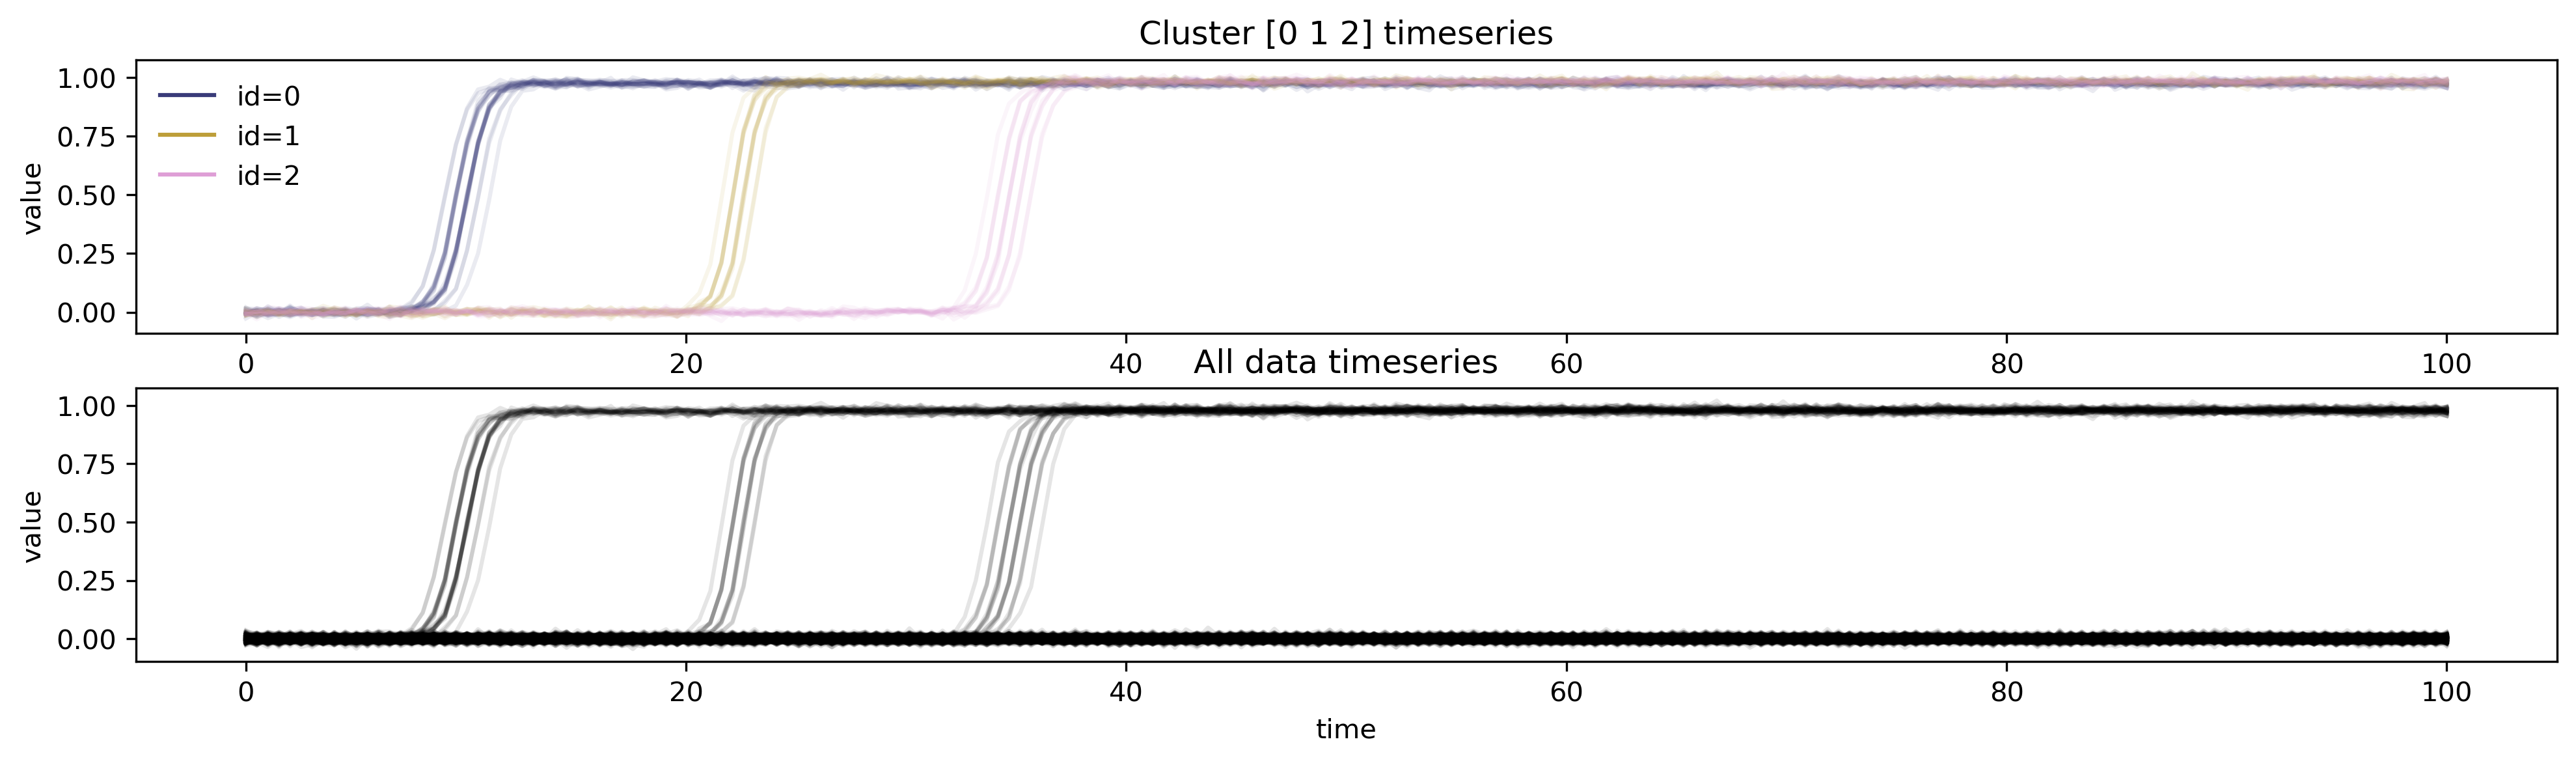

In [10]:
plot(11)

#### Cluster overlap is not really realistic as the shifts are just added on top of each other.


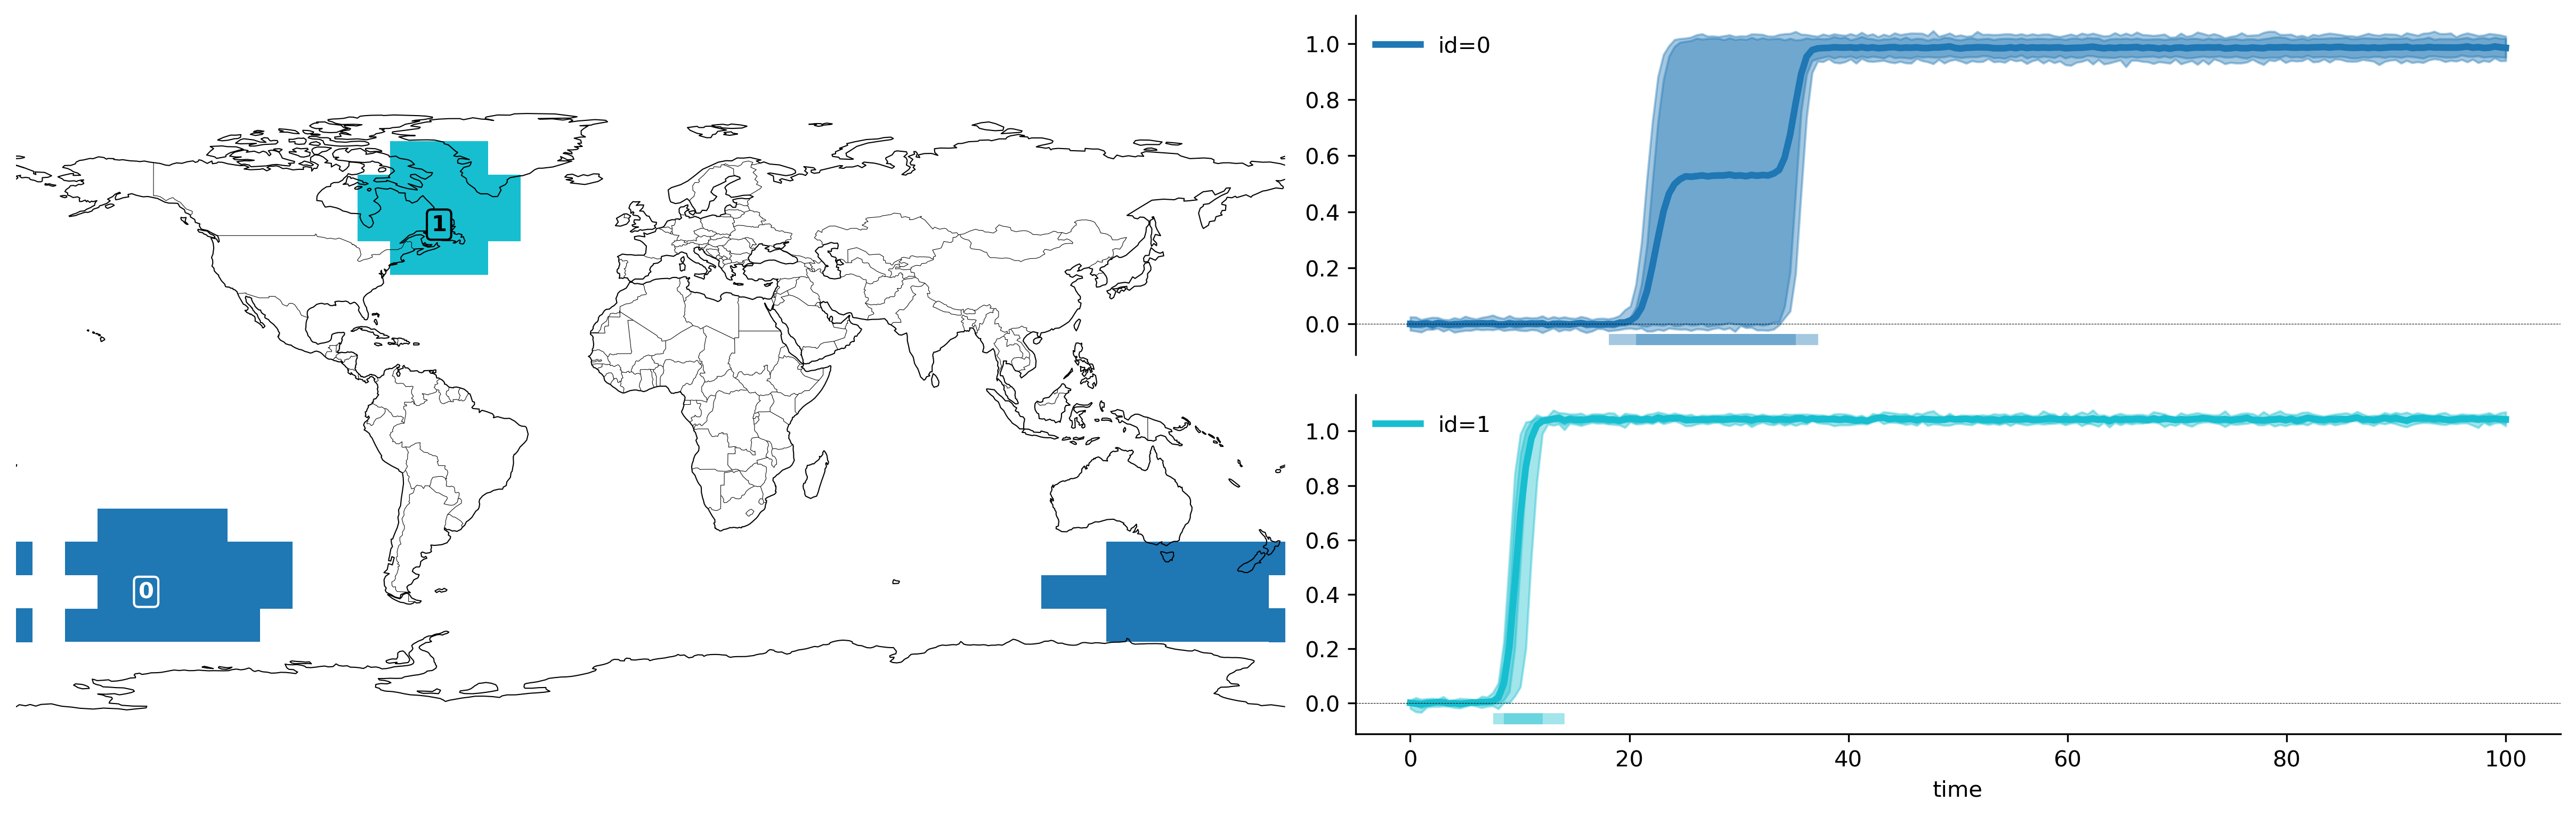

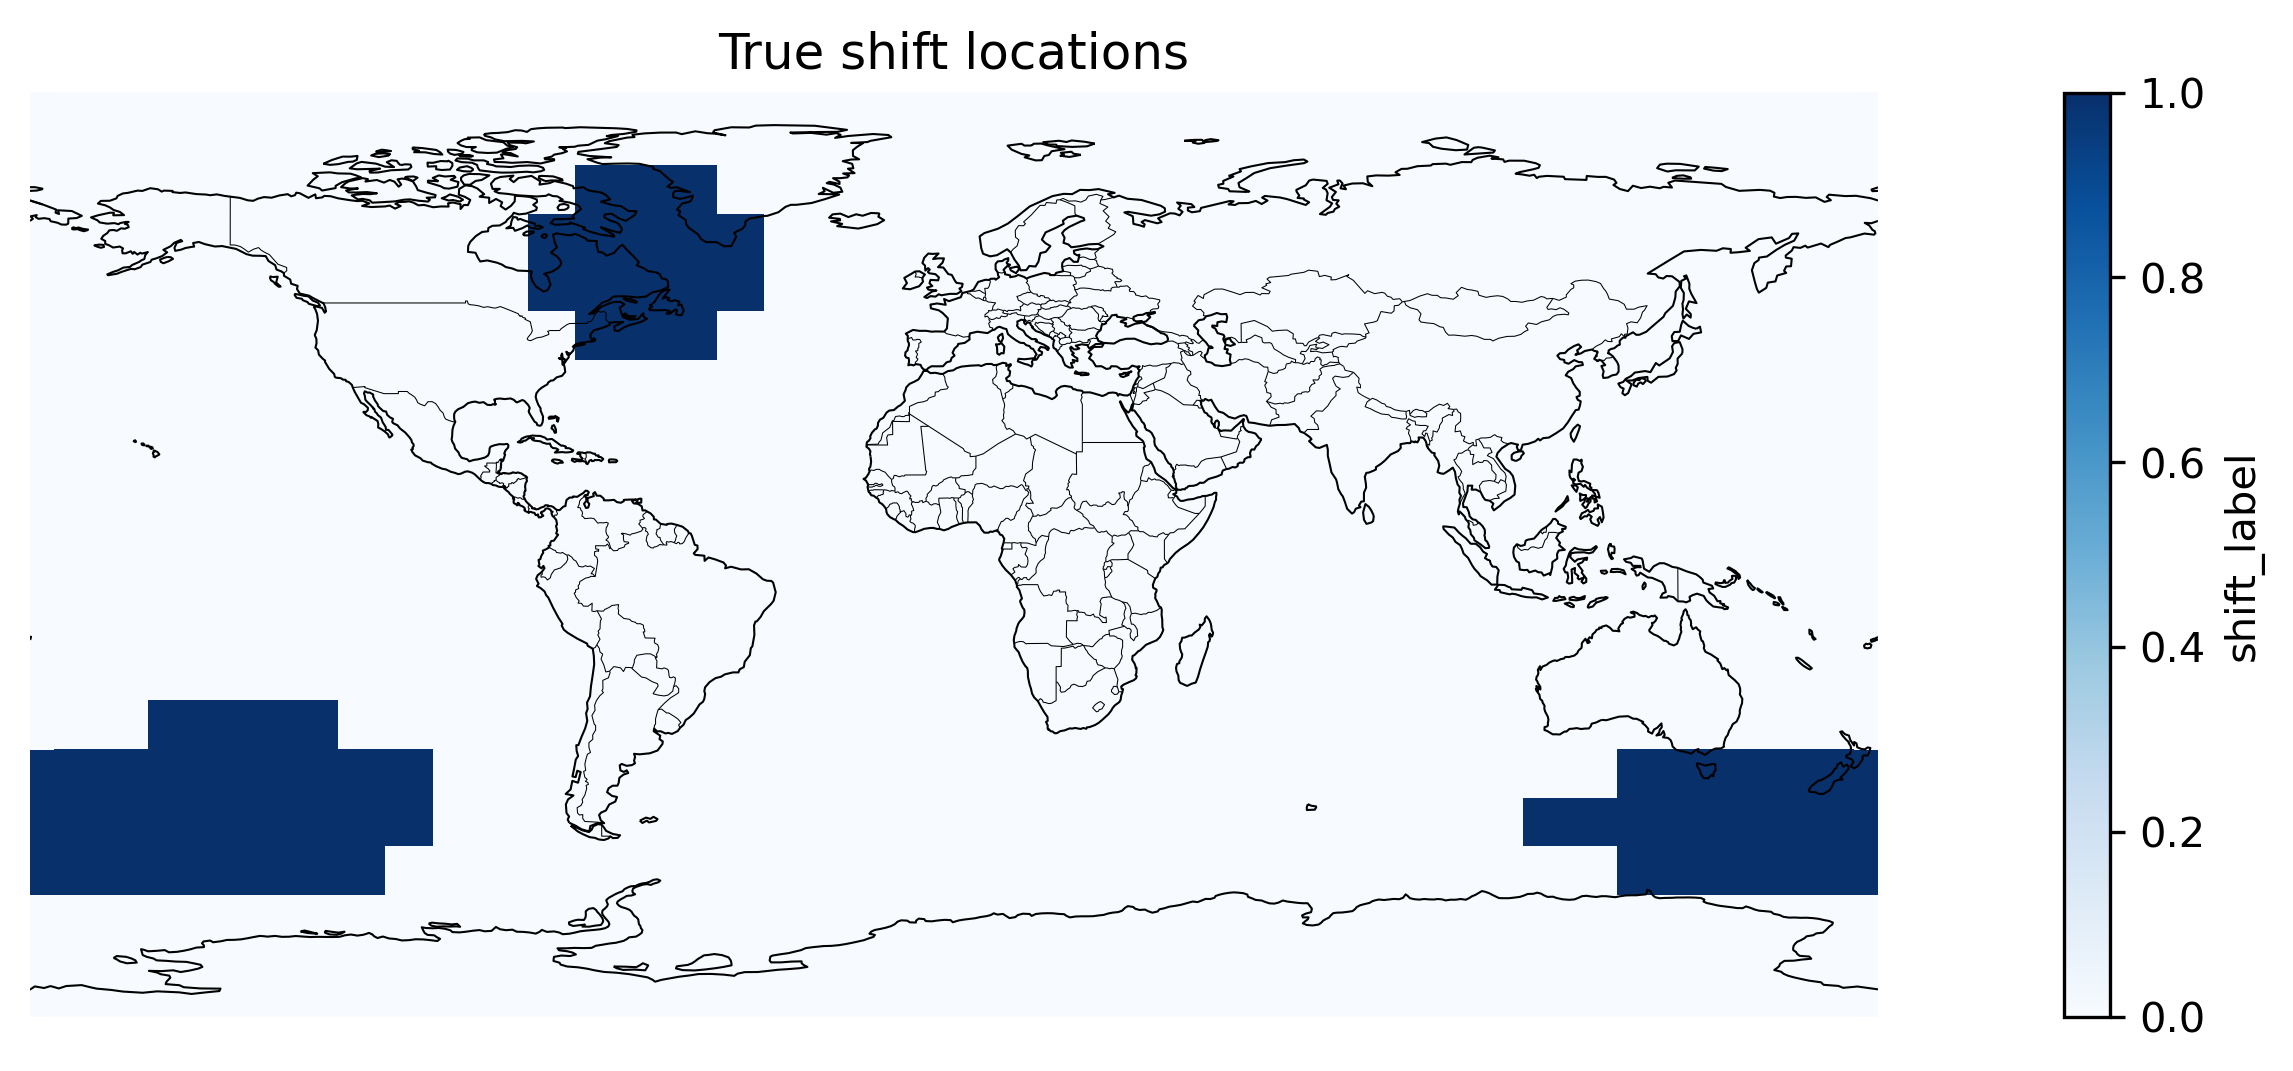

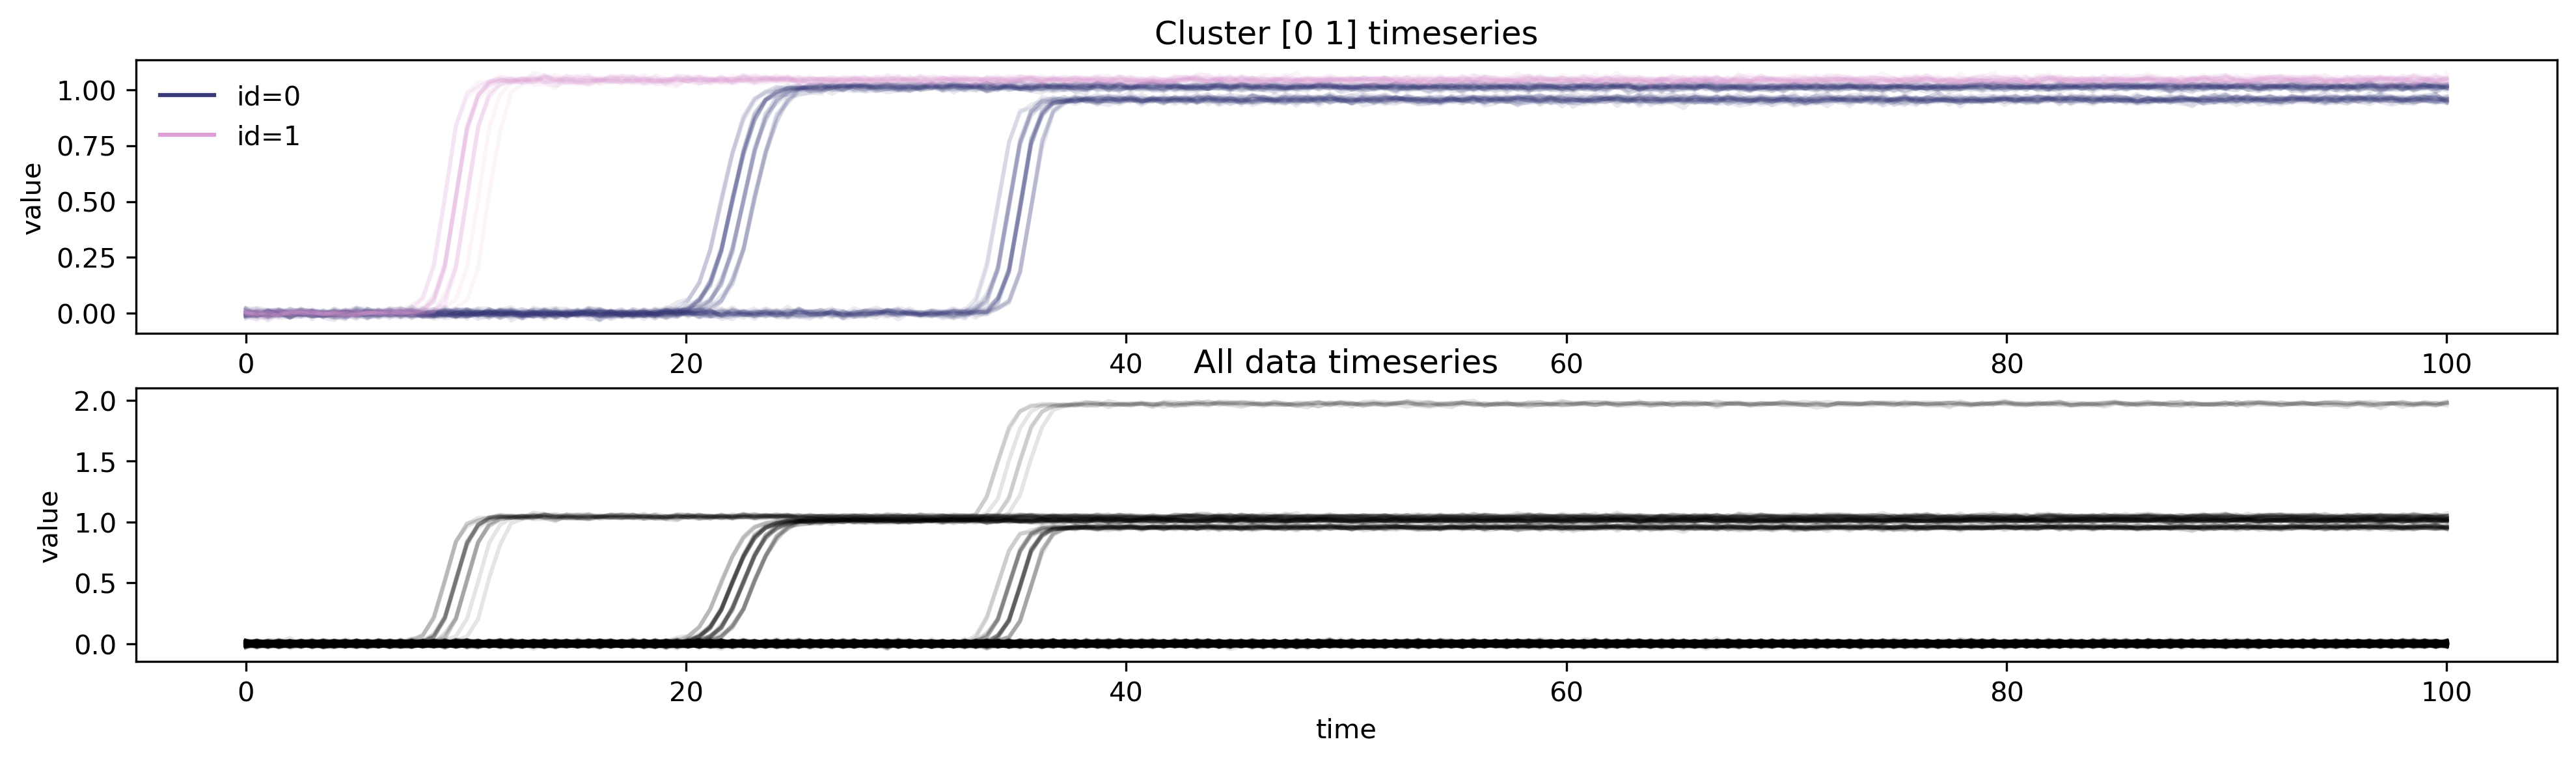

In [11]:
plot(6)

#### Example where toad finds too many clusters


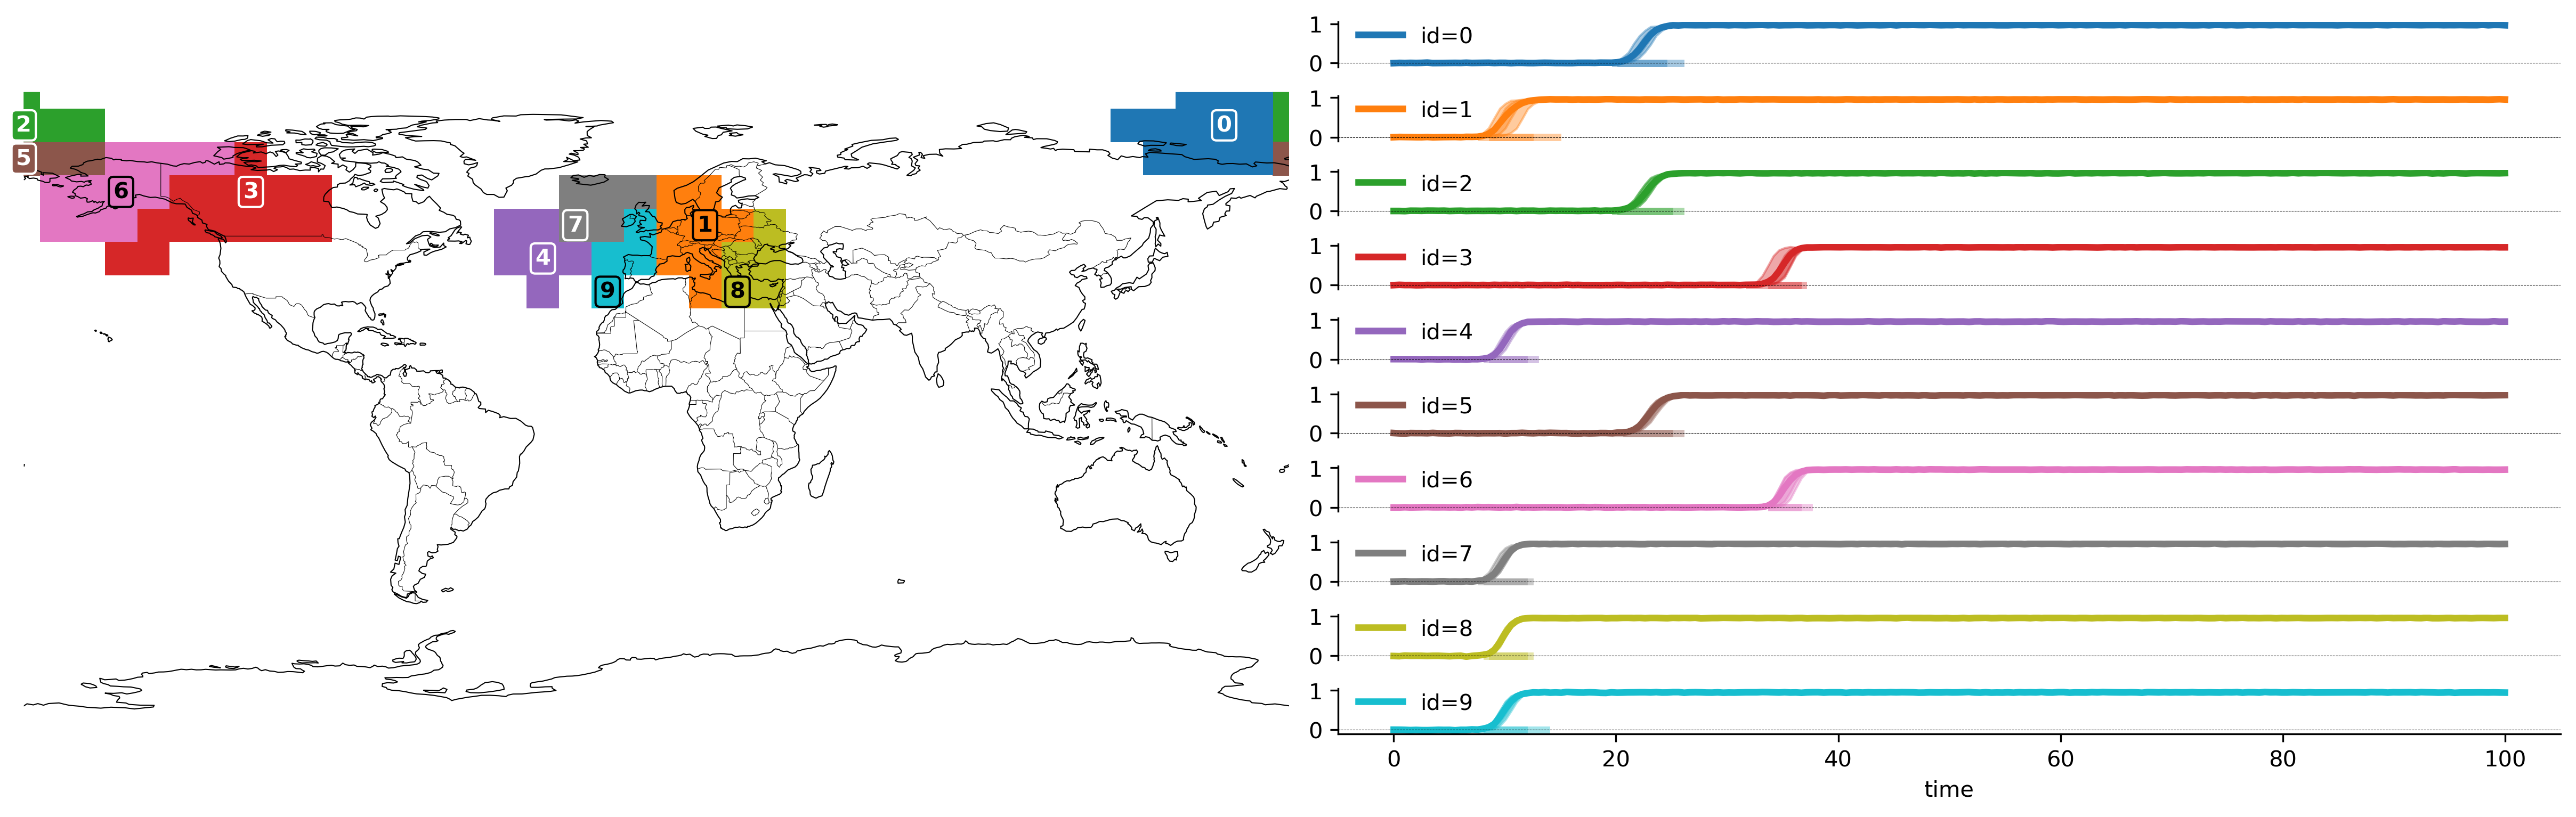

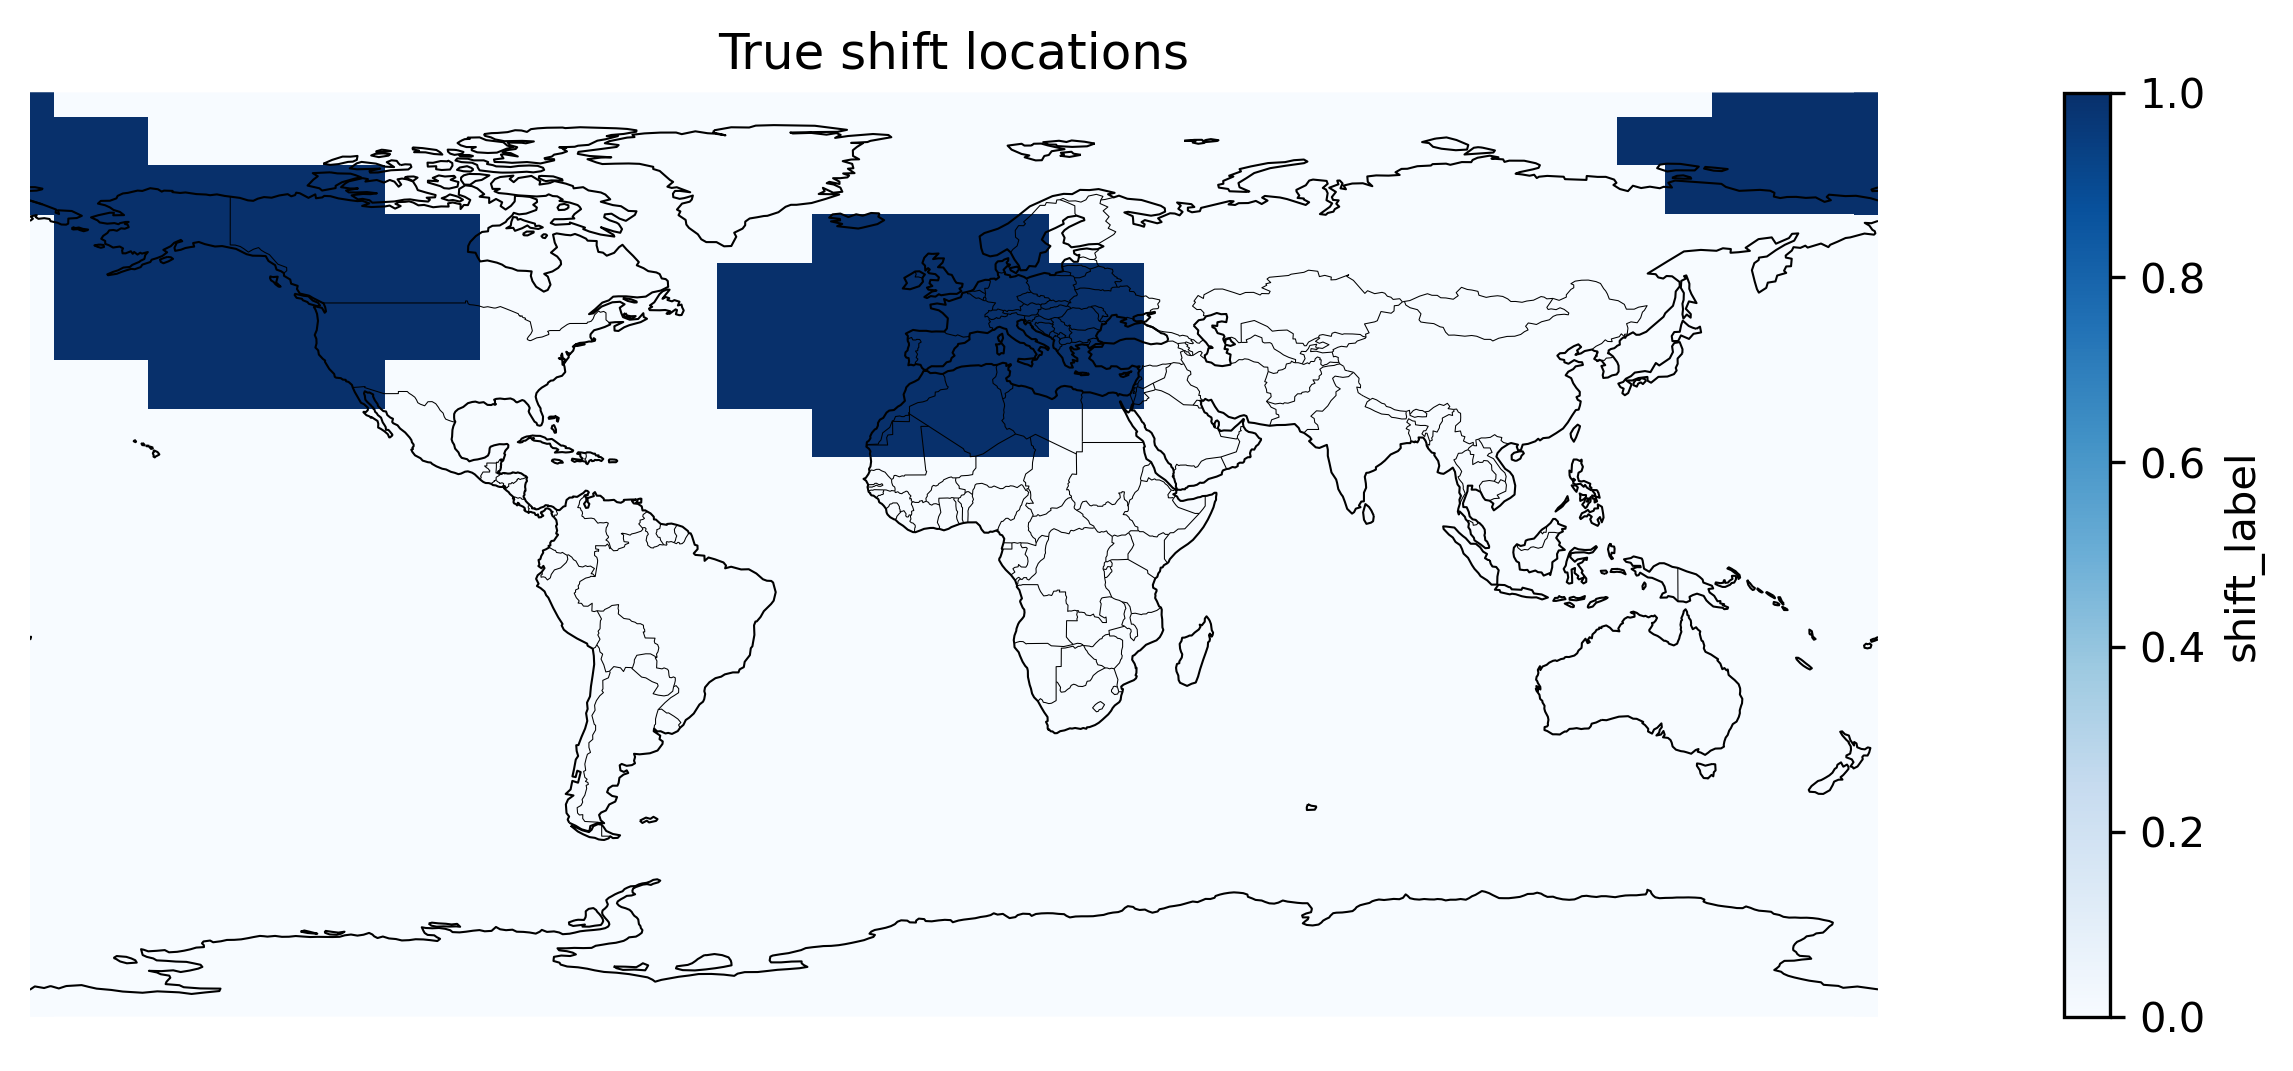

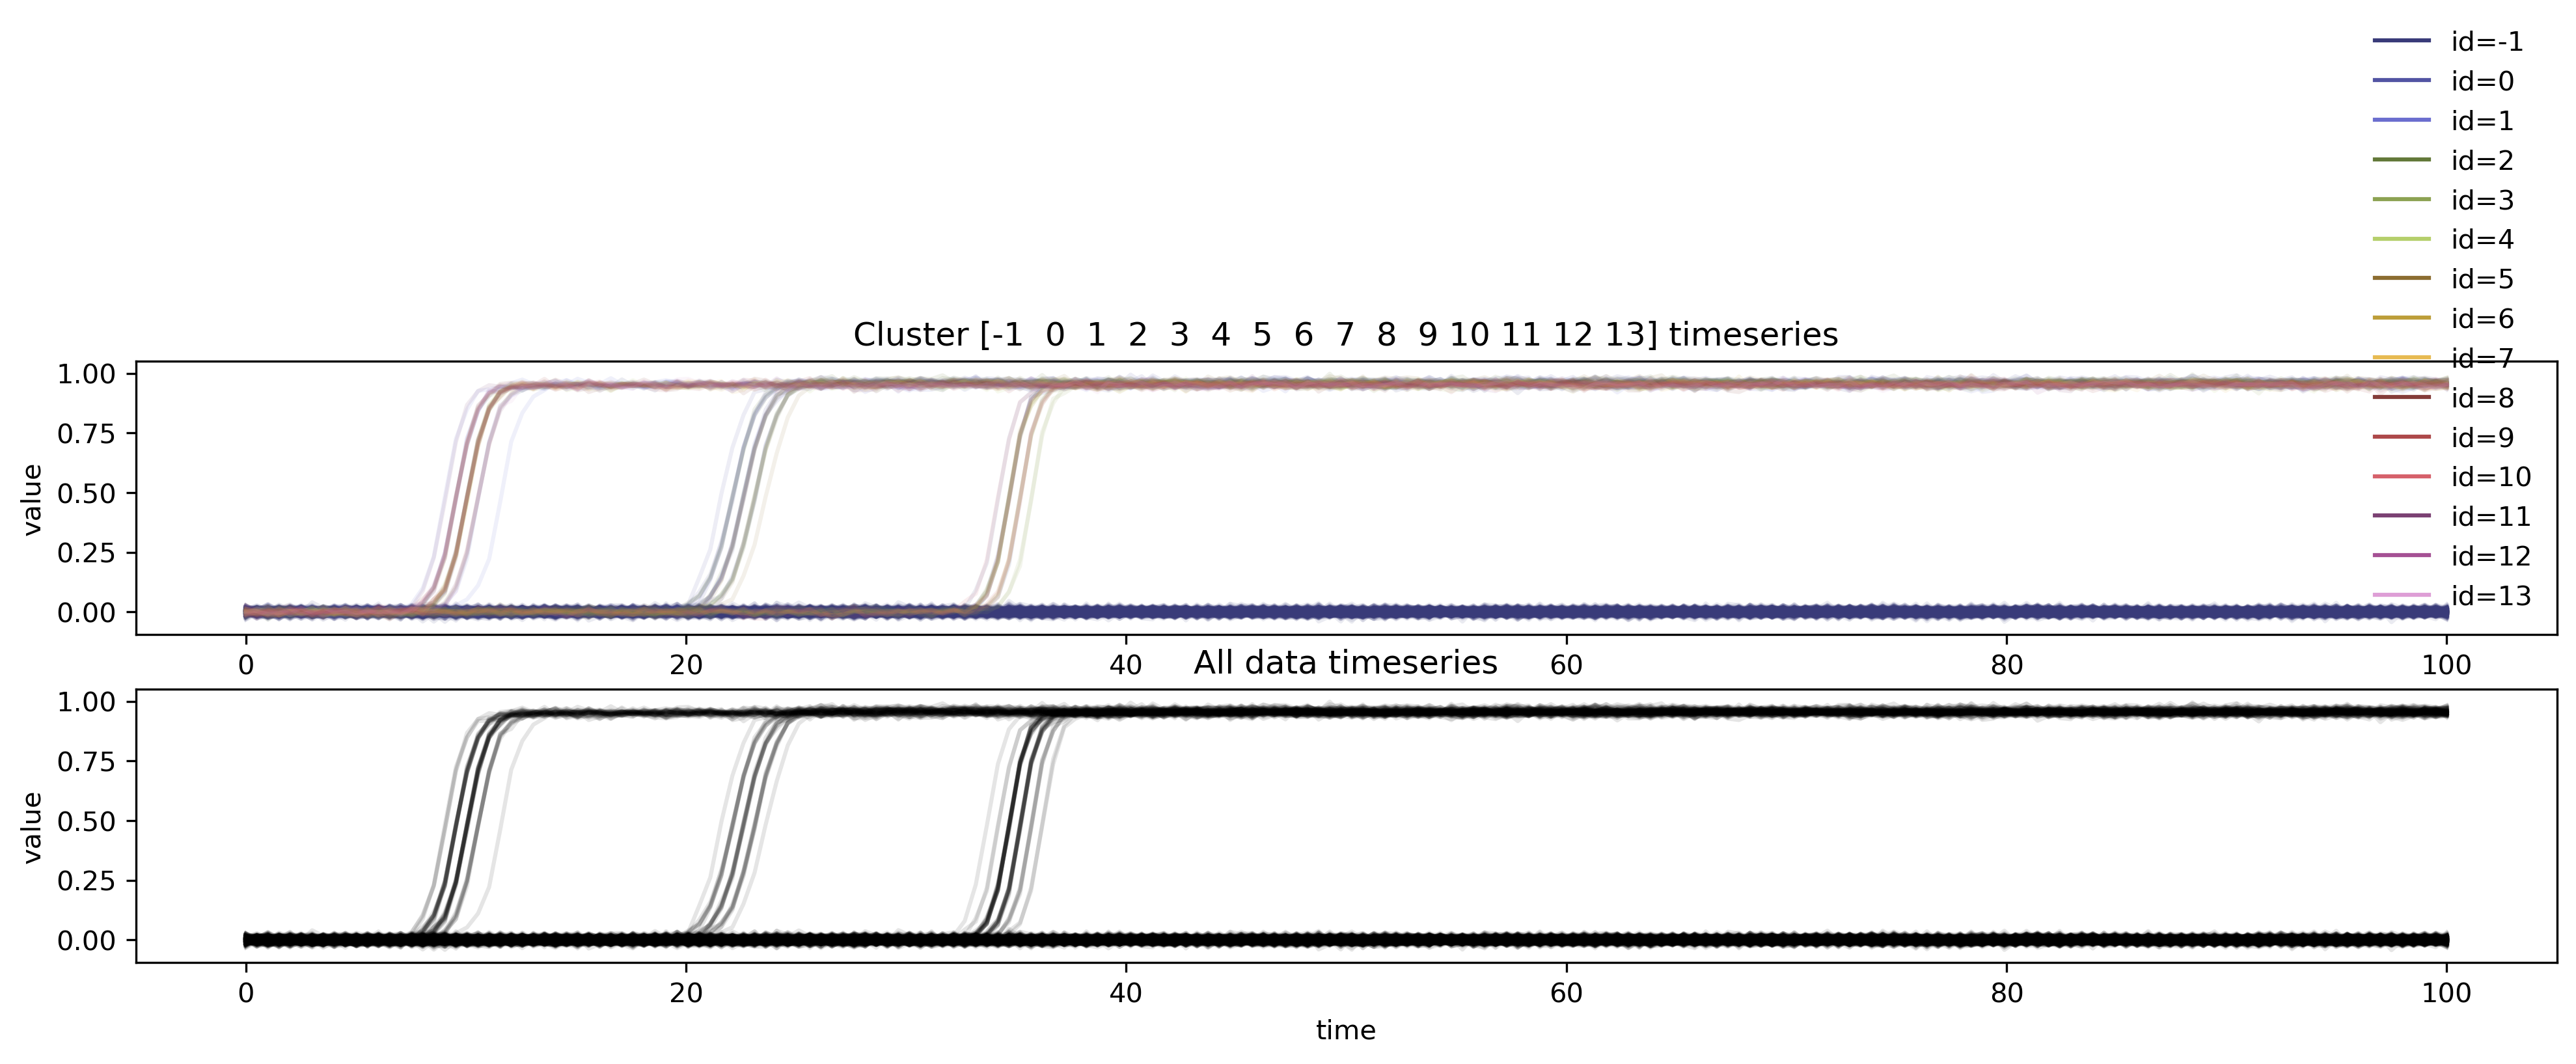

In [12]:
plot(12)